# Body positioned like "a spear" during push-off

In [4]:
import os
import cv2
import mediapipe as mp
import json
import numpy as np

# Initialize MediaPipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True, model_complexity=2, enable_segmentation=False)

def calculate_distance(point1, point2):
    """Calculate the Euclidean distance between two points."""
    return np.sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2)

def calculate_angle(a, b, c):
    """Calculate the angle formed by three points (a, b, c) where 'b' is the vertex."""
    a = np.array(a)
    b = np.array(b)
    c = np.array(c)
    ba = a - b
    bc = c - b
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(np.clip(cosine_angle, -1.0, 1.0))
    return np.degrees(angle)

def extract_keypoints_from_frame(frame_path):
    """Extract keypoints and calculated features from a single frame."""
    image = cv2.imread(frame_path)
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    result = pose.process(rgb_image)

    if result.pose_landmarks:
        h, w, _ = image.shape
        landmarks = result.pose_landmarks.landmark

        # Define key body landmarks
        nose = [landmarks[mp_pose.PoseLandmark.NOSE].x, landmarks[mp_pose.PoseLandmark.NOSE].y]
        left_shoulder = [landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER].x, landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER].y]
        right_shoulder = [landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER].x, landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER].y]
        left_hip = [landmarks[mp_pose.PoseLandmark.LEFT_HIP].x, landmarks[mp_pose.PoseLandmark.LEFT_HIP].y]
        right_hip = [landmarks[mp_pose.PoseLandmark.RIGHT_HIP].x, landmarks[mp_pose.PoseLandmark.RIGHT_HIP].y]
        left_knee = [landmarks[mp_pose.PoseLandmark.LEFT_KNEE].x, landmarks[mp_pose.PoseLandmark.LEFT_KNEE].y]
        right_knee = [landmarks[mp_pose.PoseLandmark.RIGHT_KNEE].x, landmarks[mp_pose.PoseLandmark.RIGHT_KNEE].y]
        left_ankle = [landmarks[mp_pose.PoseLandmark.LEFT_ANKLE].x, landmarks[mp_pose.PoseLandmark.LEFT_ANKLE].y]
        right_ankle = [landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE].x, landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE].y]
        left_heel = [landmarks[mp_pose.PoseLandmark.LEFT_HEEL].x, landmarks[mp_pose.PoseLandmark.LEFT_HEEL].y]
        right_heel = [landmarks[mp_pose.PoseLandmark.RIGHT_HEEL].x, landmarks[mp_pose.PoseLandmark.RIGHT_HEEL].y]

        # Calculate relevant angles
        torso_inclination = calculate_angle(nose, left_shoulder, left_hip)
        head_alignment = calculate_angle(left_shoulder, nose, right_shoulder)
        leg_extension_left = calculate_angle(left_hip, left_knee, left_ankle)
        leg_extension_right = calculate_angle(right_hip, right_knee, right_ankle)
        push_off_angle_left = calculate_angle(left_heel, left_ankle, [left_ankle[0], left_ankle[1] + 0.1])  # Vertical line
        push_off_angle_right = calculate_angle(right_heel, right_ankle, [right_ankle[0], right_ankle[1] + 0.1])

        # Calculate body height
        midpoint_ankles = [(left_ankle[0] + right_ankle[0]) / 2, (left_ankle[1] + right_ankle[1]) / 2]
        body_height = calculate_distance(nose, midpoint_ankles)
        normalized_keypoints = [
            {"x": lm.x / body_height, "y": lm.y / body_height, "z": lm.z / body_height, "visibility": lm.visibility}
            for lm in landmarks
        ]

        return {
            "keypoints": normalized_keypoints,
            "body_inclination": torso_inclination,
            "torso_angle": head_alignment,
            "left_leg_angle": leg_extension_left,
            "right_leg_angle": leg_extension_right,
            "push_off_angle_left": push_off_angle_left,
            "push_off_angle_right": push_off_angle_right,
        }
    return None


def process_frames(video_frames_dir, output_path, frame_skip=3):
    """Process frames for a video and save keypoints and features as JSON."""
    keypoints_data = []
    frame_count = 0

    for frame_file in sorted(os.listdir(video_frames_dir)):
        frame_path = os.path.join(video_frames_dir, frame_file)

        if frame_count % frame_skip != 0:
            frame_count += 1
            continue

        keypoints = extract_keypoints_from_frame(frame_path)
        if keypoints:
            keypoints_data.append(keypoints)

        frame_count += 1

    with open(output_path, 'w') as f:
        json.dump(keypoints_data, f, indent=4)

# Paths
frames_dir = "stage4-frames"
keypoints_dir = "stage4-keypoints"
os.makedirs(keypoints_dir, exist_ok=True)

# Process frames for each video
for video_name in os.listdir(frames_dir):
    video_frames_dir = os.path.join(frames_dir, video_name)
    if os.path.isdir(video_frames_dir):
        output_path = os.path.join(keypoints_dir, f"{video_name}_keypoints.json")
        process_frames(video_frames_dir, output_path, frame_skip=3)
        print(f"Keypoints extracted for {video_name}")

print("Keypoint extraction completed!")


Keypoints extracted for user102_brightness_frames
Keypoints extracted for user102_mirrored_frames
Keypoints extracted for user102_noise_frames
Keypoints extracted for user102_original_frames
Keypoints extracted for user102_rotate_frames
Keypoints extracted for user10_brightness_frames
Keypoints extracted for user10_mirrored_frames
Keypoints extracted for user10_noise_frames
Keypoints extracted for user10_original_frames
Keypoints extracted for user10_rotate_frames
Keypoints extracted for user11_brightness_frames
Keypoints extracted for user11_mirrored_frames
Keypoints extracted for user11_noise_frames
Keypoints extracted for user11_original_frames
Keypoints extracted for user11_rotate_frames
Keypoints extracted for user12_brightness_frames
Keypoints extracted for user12_mirrored_frames
Keypoints extracted for user12_noise_frames
Keypoints extracted for user12_original_frames
Keypoints extracted for user12_rotate_frames
Keypoints extracted for user13_brightness_frames
Keypoints extracte

In [7]:
import os
import json
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import pandas as pd

# Paths
json_folder = "stage4-keypoints"  # Folder containing JSON files with extracted features
labels_file = "stage4-dataset.csv"  # File with user labels (e.g., user1: 0, user2: 1)

# Load labels (assumes a CSV file with 'user' and 'label' columns)
labels_df = pd.read_csv(labels_file)
label_mapping = dict(zip(labels_df['user'], labels_df['label']))

# Dataset preparation
X = []  # Features
y = []  # Labels
max_sequence_length = 130  # Fixed sequence length for LSTM or Transformer

for json_file in sorted(os.listdir(json_folder)):
    user_id = os.path.splitext(json_file)[0]  # Extract user ID from file name
    if user_id not in label_mapping:
        print(f"Label not found for {user_id}. Skipping...")
        continue
    
    label = label_mapping[user_id]  # Get label for the user
    json_path = os.path.join(json_folder, json_file)
    
    # Load JSON data
    with open(json_path, "r") as file:
        data = json.load(file)
    
    # Extract features
    user_features = []
    for frame in data:
        try:
            # Extract specific features
            body_inclination = frame["body_inclination"]
            torso_angle = frame["torso_angle"]
            left_leg_angle = frame["left_leg_angle"]
            right_leg_angle = frame["right_leg_angle"]
            push_off_angle_left = frame["push_off_angle_left"]
            push_off_angle_right = frame["push_off_angle_right"]
            
            # Flatten normalized keypoints into a single feature vector
            keypoints = np.array([kp["x"] for kp in frame["keypoints"]] + 
                                  [kp["y"] for kp in frame["keypoints"]] + 
                                  [kp["z"] for kp in frame["keypoints"]])
            
            # Combine features into a single vector
            features = [body_inclination, torso_angle, left_leg_angle, right_leg_angle, 
                        push_off_angle_left, push_off_angle_right] + keypoints.tolist()
            user_features.append(features)
        except KeyError as e:
            print(f"Missing key {e} in {json_file}. Skipping frame...")
            continue
    
    # Append features and label
    if user_features:
        X.append(user_features)
        y.append(label)

# Pad sequences to ensure consistent lengths
X = pad_sequences(X, maxlen=max_sequence_length, dtype='float32', padding='post', truncating='post')

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

# Model Constants
sequence_length = X_train.shape[1]  # Fixed length of sequences
num_features = X_train.shape[2]  # Number of features per frame
num_classes = len(np.unique(y_train))  # Number of unique labels

print(f"Dataset prepared:")
print(f"Training set: {X_train.shape}, Validation set: {X_val.shape}")


Dataset prepared:
Training set: (73, 130, 105), Validation set: (32, 130, 105)


In [4]:
import os
import json
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import pandas as pd

# Paths
json_folder = "stage4-keypoints"  # Folder containing JSON files with extracted features
labels_file = "stage4-dataset.csv"  # File with user labels (e.g., user1: 0, user2: 1)

# Load labels (assumes a CSV file with 'user' and 'label' columns)
labels_df = pd.read_csv(labels_file)
label_mapping = dict(zip(labels_df['user'], labels_df['label']))

# Dataset preparation
X = []  # Features
y = []  # Labels
max_sequence_length = 130  # Fixed sequence length for LSTM or Transformer

for json_file in sorted(os.listdir(json_folder)):
    user_id = os.path.splitext(json_file)[0]  # Extract user ID from file name
    if user_id not in label_mapping:
        print(f"Label not found for {user_id}. Skipping...")
        continue
    
    label = label_mapping[user_id]  # Get label for the user
    json_path = os.path.join(json_folder, json_file)
    
    # Load JSON data
    with open(json_path, "r") as file:
        data = json.load(file)
    
    # Extract features
    user_features = []
    for frame in data:
        try:
            # Extract only the key features
            body_inclination = frame["body_inclination"]
            torso_angle = frame["torso_angle"]
            left_leg_angle = frame["left_leg_angle"]
            right_leg_angle = frame["right_leg_angle"]
            push_off_angle_left = frame["push_off_angle_left"]
            push_off_angle_right = frame["push_off_angle_right"]

            # Combine features into a single vector (excluding keypoints)
            features = [
                body_inclination,
                torso_angle,
                left_leg_angle,
                right_leg_angle,
                push_off_angle_left,
                push_off_angle_right
            ]
            user_features.append(features)
        except KeyError as e:
            print(f"Missing key {e} in {json_file}. Skipping frame...")
            continue
    
    # Append features and label
    if user_features:
        X.append(user_features)
        y.append(label)

# Pad sequences to ensure consistent lengths
X = pad_sequences(X, maxlen=max_sequence_length, dtype='float32', padding='post', truncating='post')

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

# Model Constants
sequence_length = X_train.shape[1]  # Fixed length of sequences
num_features = X_train.shape[2]  # Number of features per frame
num_classes = len(np.unique(y_train))  # Number of unique labels

print(f"Dataset prepared:")
print(f"Training set: {X_train.shape}, Validation set: {X_val.shape}")


Dataset prepared:
Training set: (73, 130, 6), Validation set: (32, 130, 6)


In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.compat.v1.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Calculate class weights to handle data imbalance
class_weights = compute_class_weight(
    class_weight="balanced", 
    classes=np.unique(y_train), 
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights))
print(f"Class weights: {class_weights_dict}")

# Build the LSTM model
model = Sequential([
    LSTM(128, activation='tanh', return_sequences=True, input_shape=(sequence_length, num_features)),
    Dropout(0.3),
    LSTM(64, activation='tanh', return_sequences=False),  # Add L2 regularization
    Dropout(0.3),
    Dense(64, activation='relu'),  # Add L2 regularization to dense layer
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Output: Value between 0 and 1
])

# Compile the model with Adam optimizer and binary crossentropy loss
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with class weights
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,  # Adjust based on dataset size
    batch_size=16,  # Adjust based on memory constraints
    class_weight=class_weights_dict,  # Use class weights to address imbalance
   #  callbacks=[early_stopping],  # Early stopping to prevent overfitting
    verbose=1
)

# Save the model
model.save("stage4.keras")
print("Model training complete and saved as 'stage3-spear.keras'")


Class weights: {0: 0.7448979591836735, 1: 1.5208333333333333}
Epoch 1/200
5/5 [==============================] - 10s 2s/step - loss: 0.2499 - mae: 0.5009 - val_loss: 0.2517 - val_mae: 0.5017
Epoch 2/200
5/5 [==============================] - 7s 1s/step - loss: 0.2504 - mae: 0.5019 - val_loss: 0.2513 - val_mae: 0.5013
Epoch 3/200
5/5 [==============================] - 8s 2s/step - loss: 0.2510 - mae: 0.5029 - val_loss: 0.2520 - val_mae: 0.5019
Epoch 4/200
5/5 [==============================] - 7s 1s/step - loss: 0.2502 - mae: 0.5013 - val_loss: 0.2505 - val_mae: 0.5005
Epoch 5/200
5/5 [==============================] - 8s 2s/step - loss: 0.2506 - mae: 0.5006 - val_loss: 0.2495 - val_mae: 0.4995
Epoch 6/200
5/5 [==============================] - 7s 2s/step - loss: 0.2509 - mae: 0.5003 - val_loss: 0.2491 - val_mae: 0.4991
Epoch 7/200
5/5 [==============================] - 7s 1s/step - loss: 0.2501 - mae: 0.4993 - val_loss: 0.2496 - val_mae: 0.4996
Epoch 8/200
5/5 [========================

In [5]:
import pandas as pd
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np

# Define threshold
threshold = 0.5  # Predictions above this are classified as 1 (incorrect), below as 0 (correct)

# Load the trained model
model = load_model("stage4.keras")

# Predict on the validation set
y_pred = model.predict(X_val).flatten()  # Flatten predictions for simplicity

# Apply threshold to classify
y_classified = [1 if pred > threshold else 0 for pred in y_pred]

# Convert results to a DataFrame for analysis
results_df = pd.DataFrame({
    'True Label': y_val,
    'Predicted Value': y_pred,
    'Predicted Class': y_classified
})

# Save results to a CSV file for analysis
results_df.to_csv("validation_results.csv", index=False)
print("Validation results saved to 'validation_results.csv'.")

# Display the first few rows
print(results_df.head())

# Calculate and display accuracy
accuracy = accuracy_score(y_val, y_classified)
print(f"Accuracy: {accuracy:.2f}")

# Confusion matrix
conf_matrix = confusion_matrix(y_val, y_classified)
print("Confusion Matrix:")
print(conf_matrix)

# Classification report for detailed metrics
class_report = classification_report(y_val, y_classified, target_names=["Correct", "Incorrect"])
print("Classification Report:")
print(class_report)


1/1 [==============================] - 1s 609ms/step
Validation results saved to 'validation_results.csv'.
   True Label  Predicted Value  Predicted Class
0           0         0.498851                0
1           0         0.498851                0
2           1         0.498851                0
3           1         0.498851                0
4           0         0.498851                0
Accuracy: 0.66
Confusion Matrix:
[[21  0]
 [11  0]]
Classification Report:
              precision    recall  f1-score   support

     Correct       0.66      1.00      0.79        21
   Incorrect       0.00      0.00      0.00        11

    accuracy                           0.66        32
   macro avg       0.33      0.50      0.40        32
weighted avg       0.43      0.66      0.52        32



c:\Users\nikit\Anaconda3\envs\tf_gpu_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\nikit\Anaconda3\envs\tf_gpu_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\nikit\Anaconda3\envs\tf_gpu_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Calculate class weights to handle data imbalance
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights))
print(f"Class weights: {class_weights_dict}")

# Build the CNN model
model = Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(sequence_length, num_features)),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Output: Binary classification (0 or 1)
])

# Compile the model with Adam optimizer and binary crossentropy loss
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error', metrics=['mae'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with class weights
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10000,
    batch_size=16,
    class_weight=class_weights_dict,  # Handle class imbalance
   #  callbacks=[early_stopping],
    verbose=1
)

# Save the model
model.save("stage4-cnn2.keras")
print("Model training complete and saved as 'stage4-cnn.keras'")


Class weights: {0: 0.7448979591836735, 1: 1.5208333333333333}
Epoch 1/10000
5/5 [==============================] - 1s 52ms/step - loss: 0.4478 - mae: 0.4393 - val_loss: 0.4194 - val_mae: 0.4660
Epoch 2/10000
5/5 [==============================] - 0s 20ms/step - loss: 0.5171 - mae: 0.4726 - val_loss: 0.4505 - val_mae: 0.4683
Epoch 3/10000
5/5 [==============================] - 0s 12ms/step - loss: 0.6028 - mae: 0.5037 - val_loss: 0.3597 - val_mae: 0.3974
Epoch 4/10000
5/5 [==============================] - 0s 13ms/step - loss: 0.4399 - mae: 0.3601 - val_loss: 0.3351 - val_mae: 0.3505
Epoch 5/10000
5/5 [==============================] - 0s 11ms/step - loss: 0.5048 - mae: 0.4188 - val_loss: 0.3405 - val_mae: 0.3444
Epoch 6/10000
5/5 [==============================] - 0s 12ms/step - loss: 0.5100 - mae: 0.4193 - val_loss: 0.3301 - val_mae: 0.3408
Epoch 7/10000
5/5 [==============================] - 0s 12ms/step - loss: 0.5345 - mae: 0.4587 - val_loss: 0.3169 - val_mae: 0.3437
Epoch 8/10000


In [8]:
import pandas as pd
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np

# Define threshold
threshold = 0.5  # Predictions above this are classified as 1 (incorrect), below as 0 (correct)

# Load the trained model
model = load_model("stage4-cnn.keras")

# Predict on the validation set
y_pred = model.predict(X_val).flatten()  # Flatten predictions for simplicity

# Apply threshold to classify
y_classified = [1 if pred > threshold else 0 for pred in y_pred]

# Convert results to a DataFrame for analysis
results_df = pd.DataFrame({
    'True Label': y_val,
    'Predicted Value': y_pred,
    'Predicted Class': y_classified
})

# Save results to a CSV file for analysis
results_df.to_csv("validation_results.csv", index=False)
print("Validation results saved to 'validation_results.csv'.")

# Display the first few rows
print(results_df.head())

# Calculate and display accuracy
accuracy = accuracy_score(y_val, y_classified)
print(f"Accuracy: {accuracy:.2f}")

# Confusion matrix
conf_matrix = confusion_matrix(y_val, y_classified)
print("Confusion Matrix:")
print(conf_matrix)

# Classification report for detailed metrics
class_report = classification_report(y_val, y_classified, target_names=["Correct", "Incorrect"])
print("Classification Report:")
print(class_report)


1/1 [==============================] - 1s 780ms/step
Validation results saved to 'validation_results.csv'.
   True Label  Predicted Value  Predicted Class
0           0     1.720398e-12                0
1           0     4.989142e-04                0
2           1     1.000000e+00                1
3           1     1.000000e+00                1
4           0     1.010989e-14                0
Accuracy: 0.84
Confusion Matrix:
[[16  5]
 [ 0 11]]
Classification Report:
              precision    recall  f1-score   support

     Correct       1.00      0.76      0.86        21
   Incorrect       0.69      1.00      0.81        11

    accuracy                           0.84        32
   macro avg       0.84      0.88      0.84        32
weighted avg       0.89      0.84      0.85        32



1/1 [==============================] - 0s 16ms/step
[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1]


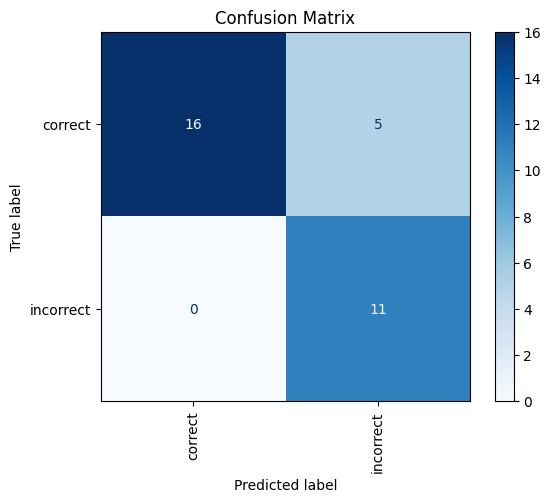

Accuracy: 0.84


In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt

# Define a single threshold for classification
# threshold = 0.005  # Adjust this value to experiment with different thresholds
threshold = 0.5  # Predictions above this are classified as `correct` (0), below as `incorrect` (1)


# Predict on validation set
y_pred = model.predict(X_val).flatten()  # Flatten the predictions for simplicity

# Apply threshold
# y_classified = [0 if pred > threshold else 1 for pred in y_pred]  # 0 = correct, 1 = incorrect

y_classified = []
for pred in y_pred:
    if pred > threshold:
        y_classified.append(1)  # Correct
    else:
        y_classified.append(0)  # Incorrect
print(y_classified)

# Classify predictions based on the threshold
# y_classified = [0 if pred > threshold else 1 for pred in y_pred]  # `0` = correct, `1` = incorrect

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, labels):
    # Ensure label order matches the data
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])  # Numerical order: 0 = correct, 1 = incorrect
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues', xticks_rotation='vertical')
    plt.title('Confusion Matrix')
    plt.grid(False)
    plt.show()

# Ensure the order of labels matches the confusion matrix
true_labels = ["correct", "incorrect"]  # Match this to 0 = correct, 1 = incorrect

# Plot confusion matrix
plot_confusion_matrix(y_val, y_classified, labels=true_labels)

# Calculate and print accuracy
accuracy = accuracy_score(y_val, y_classified)
print(f"Accuracy: {accuracy:.2f}")
